### <b> Multiclass Classification of Images using CNNs </b>


The notebook is broken into the following sections:
1. Loading MNIST (no ACT's)
2. Building the CNN
3. Building the Trainer
4. Training the Network
5. Network Accuracy
6. Visualizing CNN Layers
7. Comparing with a Fully Connected Network


In [ ]:
# Setting some hyperparameters and making sure we have a GPU
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import tqdm
import os
from torchviz import make_dot


# Select GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10  # there are 10 digits: 0 to 9
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# This line prints out the type of device you will run the notebook in.
print(str(device))

cuda:0


### Loading MNIST
Here we are loading the MNIST dataset. This dataset consists of 60,000 training images and 10,000 test images. Due to the inability of downloading data from the internet on Adroit, we already have downloaded the MNIST datasets and stored them in our COS324 Adroit directory (File path is shown in the below code cell. Should be changed if working on a local instance of Jupyter.). We have additionally stored the data as PyTorch tensors and performed the necessary data normalizations. The below cell is simply loading and preparing the MNIST train and test datasets.

Each image is a 28-by-28 grayscale image, so it is represented by a 28-by-28 array. The labels are 0 to 9, representing digits 0-9.

In [ ]:
from torch.utils.data import DataLoader

# MNIST dataset
mnist_file_path = "/home/COS324/assignments/PA4/"
train_dataset = torch.load(mnist_file_path + "mnist_train.pt", weights_only=False)
test_dataset = torch.load(mnist_file_path + "mnist_test.pt", weights_only=False)

# train_loader returns batches of training data. See how train_loader is used in the Trainer class later
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)

##ASSERTS: checking whether the data is loaded as expected
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

Now we visualize some samples from the dataset.

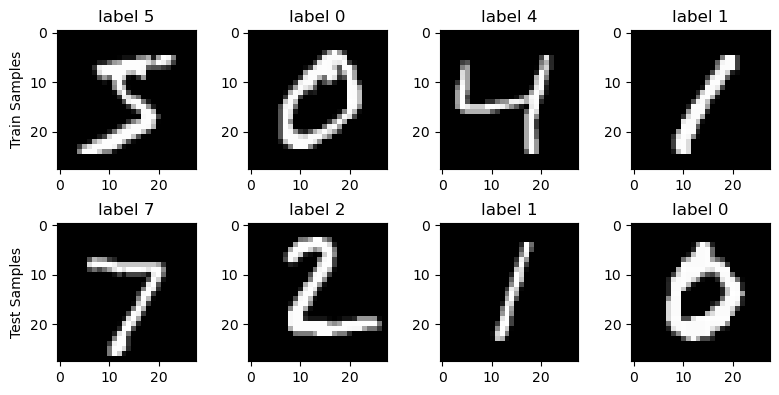

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for sample_idx in range(4):

    train_image, train_label = train_dataset[sample_idx]
    axs[0, sample_idx].imshow(train_image.squeeze(0), cmap='grey')
    axs[0, sample_idx].set_title(f"label {train_label}")

    test_image, test_label = test_dataset[sample_idx]
    axs[1, sample_idx].imshow(test_image.squeeze(0), cmap='grey')
    axs[1, sample_idx].set_title(f"label {test_label}")

axs[0, 0].set_ylabel("Train Samples")
axs[1, 0].set_ylabel("Test Samples")
plt.tight_layout()
plt.show()

### Building the network
Let's build a CNN to classify MNIST images. You will build a CNN with the following architecture:

Input:
0. The input is a 3-dimensional array with size you have seen in ACT 0.

Network:
1.   `conv1`: 2D Convolutional Layer with 16 output channels, 5-by-5 kernels, **and padding of size 2**, activation function RELU
2.   `pool1`: Max Pooling with a 2-by-2 kernel and a stride of size 2
3.   `conv2`: 2D Convolutional Layer with 32 output channels, 5-by-5 kernels, **and no padding**, activation function RELU
4.   `pool2`: Max Pooling with a 2-by-2 kernel and a stride of size 2
5.   `fc1`: Fully Connected Layer with output size 120 with RELU activation
5.   `fc2`: Fully Connected Layer with output size 84 with RELU activation
6.   `fc3`: Fully Connected Layer with output of size 10 (no activation function)

This is very similar to one of the first convolutional neural networks in the world developed by Yann Lecun et. al. Fore more details, see the [LeNet-5 paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) or the [Wikipedia page](https://en.wikipedia.org/wiki/LeNet). It used to take several days to train this model on a non-parallel 200MHz CPU.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


### ACT1-ACT9:
### Complete the code below based on the architecture described above
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2) #ACT1
        self.pool1 = nn.MaxPool2d(2, 2) #ACT2
        self.conv2 = nn.Conv2d(16, 32, 5,) #ACT3
        self.pool2 = nn.MaxPool2d(2, 2) #ACT4

        # ACT5 compute the size of the the input for the first fully connected layer.
        # You can track what happens to a image when passes through the previous layers.
        # You will endup with 32 channels, each of size x-by-x,
        # therefore the size of input is (32*x*x) - you need to compute x and fill the code below
        self.size_linear = 32 * 5 * 5 #ACT5
        self.fc1 = nn.Linear(self.size_linear, 120)
        self.fc2 = nn.Linear(120, 84) #ACT6.1
        self.fc3 = nn.Linear(84, 10) #ACT6.2

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # we provide this line for you
        x = self.pool2(F.relu(self.conv2(x)))# ACT7: apply the second convolution and max pooling
        x = x.view(x.size(0), 32 * 5 * 5) # ACT8: flatten x into a 1D vector (see https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view)
        x = F.relu(self.fc1(x)) # ACT9.1: Apply the first fc layer (with ReLU)
        x = F.relu(self.fc2(x))# ACT9.2: Apply the second fc layer (with ReLU)
        x = self.fc3(x)# ACT9.3: Apply the last fully connected layer (no ReLU)
        return x

##ASSERT: checks if your CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 54 random images
    test_data = torch.stack([train_dataset[i][0] for i in range(64)]).to(device)
    test_net = ConvNet().to(device)
    out = test_net.forward(test_data)
    print(out.shape)
    # the output should have size (64,10)
    assert(out.size()==(64,10))


torch.Size([64, 10])


Now we can check how many parameters are there in the model

In [ ]:
def count_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        print(f"{name}:\t {param.shape}")
        total_params += len(param.view(-1))
    print(f"Total parameters: {total_params}")

count_parameters(ConvNet())

conv1.weight:	 torch.Size([16, 1, 5, 5])
conv1.bias:	 torch.Size([16])
conv2.weight:	 torch.Size([32, 16, 5, 5])
conv2.bias:	 torch.Size([32])
fc1.weight:	 torch.Size([120, 800])
fc1.bias:	 torch.Size([120])
fc2.weight:	 torch.Size([84, 120])
fc2.bias:	 torch.Size([84])
fc3.weight:	 torch.Size([10, 84])
fc3.bias:	 torch.Size([10])
Total parameters: 120382


### Visualize Network


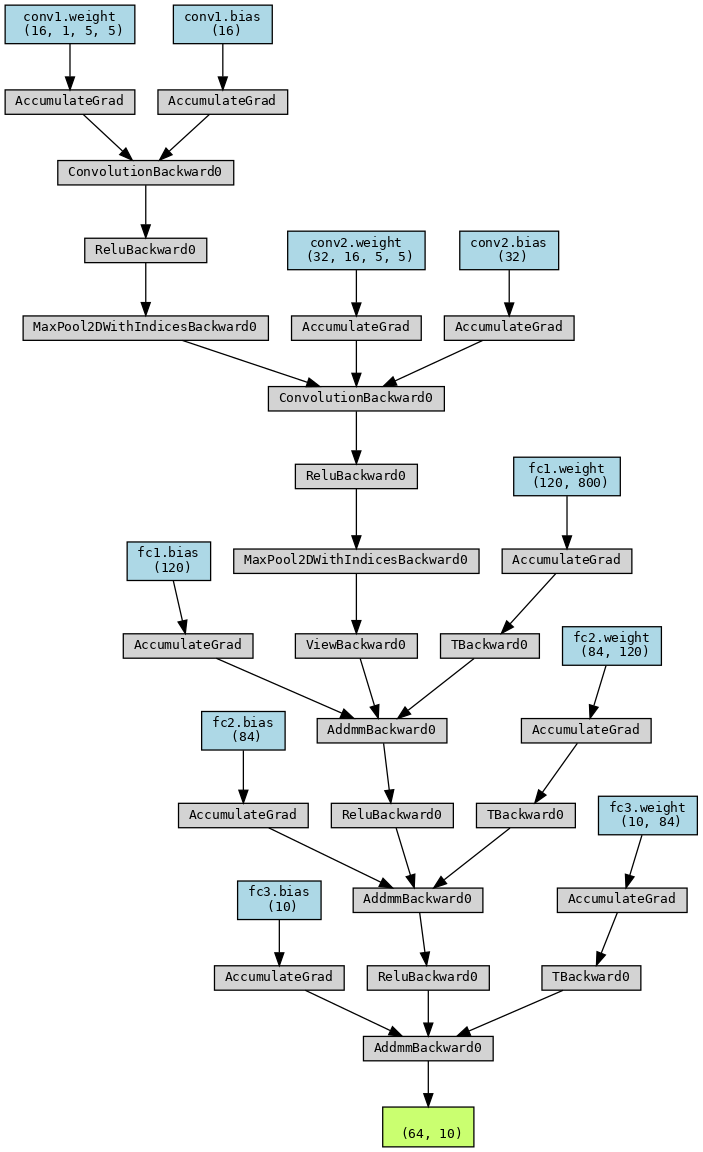

In [ ]:
from IPython.display import Image

test_data = torch.stack([train_dataset[i][0] for i in range(64)])
test_net = ConvNet()
out = test_net.forward(test_data)
params = dict(test_net.named_parameters()) # ACT10
dot = make_dot(out, params=params)
dot.format = "png"
dot.render(filename="network_graph")
Image(filename="network_graph.png")

### Preparing for training: Build accuracy checker


In [ ]:
def compute_accuracy(logits, labels):
    # Act11 - Implement the accuracy function (no for loops please!)
    predicted_label = torch.argmax(logits, dim=1)#TODO
    correct = torch.sum(predicted_label==labels) #TODO
    accuracy = correct / len(labels)
    return accuracy

# Testing
test_logits = torch.eye(10)
labels = torch.arange(10)
labels[-3:] = 1
assert compute_accuracy(test_logits, labels) == 0.7

### Building the trainer


In [ ]:
### ACT12-ACT18 Please fill the code below
class Trainer():
    def __init__(self,
                 net,
                 optimizer,
                 loss_function,
                 train_loader,
                 test_loader
                 ):

        self.net = net
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train_epoch(self):
        """
        This method takes one pass through the training dataloader
        """
        dataloader_progress = tqdm.tqdm(self.train_loader, desc='Training') # for progress bar display

        total_loss = 0.0
        total_accuracy = 0.0
        total_steps = 0

        for data in dataloader_progress:

            # Moving this batch to GPU
            # Note that X has shape (batch_size, number of channels, height, width)
            # which is equal to (256,1,28,28) since our default batch_size = 256 and
            # the image has only 1 channel
            X = data[0].to(device)
            y = data[1].to(device)

            # Zero the gradient in the optimizer i.e. self.optimizer
            self.optimizer.zero_grad()

            # Getting the output of the Network
            output = self.net(X) #TODO

            # Computing loss using loss function i.e. self.loss_function
            loss = self.loss_function(output, y) #TODO

            # Computing accuracy using the compute_accuracy function defined above
            accuracy = compute_accuracy(output, y) #TODO

            # Backpropagate the loss to compute gradients of parameters
            loss.backward()

            # Call the optimizer i.e. self.optimizer
            self.optimizer.step()

            total_loss += loss.item()
            total_accuracy += accuracy
            total_steps += 1

            dataloader_progress.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{accuracy * 100:.2f}%"})

        epoch_loss = total_loss / total_steps
        epoch_accuracy = total_accuracy / total_steps

        return epoch_loss, epoch_accuracy

    def test_epoch(self):
        """
        This method takes one pass through the test dataloader
        Please write this method based on the train_epoch function you have created above
        When doing the modifications, keep the following things in mind

        1. We are not computing gradients (use with torch.no_grad())
        2. We are not using optimizers / taking optimizer steps
        """

        dataloader_progress = tqdm.tqdm(self.test_loader, desc='Testing')
        # Write test_epoch function returning the average loss (epoch_loss) and accuracy (epoch_accuracy) over the test set
        total_loss = 0
        total_accuracy = 0
        total_steps = 0
        with torch.no_grad():
            for data in dataloader_progress:
                X = data[0].to(device)
                y = data[1].to(device)
                output = self.net(X)
                loss = self.loss_function(output, y)
                accuracy = compute_accuracy(output, y)

                dataloader_progress.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{accuracy * 100:.2f}%"})
                total_loss += loss.item()
                total_accuracy += accuracy
                total_steps += 1




        epoch_loss = total_loss/total_steps
        epoch_accuracy = total_accuracy/total_steps

        return epoch_loss, epoch_accuracy #TODO

    def train(self, epochs):

        # Initialize arrays to store the losses and accuracies
        stats = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
        }

        for epoch in tqdm.trange(epochs, disable=True):

            # Train the model over the training set and record the training loss / acc
            train_loss, train_acc = self.train_epoch()

            # Test the model over the testing set and record the testing loss / acc
            test_loss, test_acc = self.test_epoch()

            stats['train_loss'].append(train_loss)
            stats['test_loss'].append(test_loss)
            stats['train_acc'].append(train_acc)
            stats['test_acc'].append(test_acc)

            print(f"Epoch {epoch + 1}: train loss {train_loss:.4f}, train acc {100 * train_acc:.2f}%, test loss {test_loss:.4f}, test acc {100 * test_acc:.2f}%\n")
        return stats

### Training the network
We will find the right learning rate that results in less than 0.03 loss after 10 epochs of training.

In [ ]:
import torch.optim as optim


learning_rate = 0.03

torch.manual_seed(324) # random seed for reproducibility

net = ConvNet()
net = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net, opt, loss_function, train_loader, test_loader)
stats = trainer.train(num_epochs)

###ASSERTS
assert(stats['train_loss'][-1] < 0.03)
assert(len(stats['train_loss'])==num_epochs)  # because you record the loss after each epoch

Testing: 100%|██████████| 40/40 [00:01<00:00, 35.46it/s, loss=0.0025, acc=100.00%]


Epoch 1: train loss 0.5720, train acc 81.78%, test loss 0.0760, test acc 97.58%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.00it/s, loss=0.0003, acc=100.00%]


Epoch 2: train loss 0.0665, train acc 98.00%, test loss 0.0472, test acc 98.57%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.73it/s, loss=0.0003, acc=100.00%]


Epoch 3: train loss 0.0462, train acc 98.57%, test loss 0.0374, test acc 98.75%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.81it/s, loss=0.0022, acc=100.00%]


Epoch 4: train loss 0.0356, train acc 98.88%, test loss 0.0342, test acc 98.80%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.63it/s, loss=0.0001, acc=100.00%]


Epoch 5: train loss 0.0293, train acc 99.06%, test loss 0.0279, test acc 99.12%



Testing: 100%|██████████| 40/40 [00:01<00:00, 35.03it/s, loss=0.0001, acc=100.00%]


Epoch 6: train loss 0.0234, train acc 99.30%, test loss 0.0313, test acc 99.02%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.70it/s, loss=0.0000, acc=100.00%]


Epoch 7: train loss 0.0213, train acc 99.31%, test loss 0.0306, test acc 99.08%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.59it/s, loss=0.0000, acc=100.00%]


Epoch 8: train loss 0.0175, train acc 99.46%, test loss 0.0282, test acc 99.07%



Testing: 100%|██████████| 40/40 [00:01<00:00, 35.38it/s, loss=0.0000, acc=100.00%]


Epoch 9: train loss 0.0153, train acc 99.53%, test loss 0.0307, test acc 99.07%



Testing: 100%|██████████| 40/40 [00:01<00:00, 35.16it/s, loss=0.0002, acc=100.00%]

Epoch 10: train loss 0.0140, train acc 99.57%, test loss 0.0343, test acc 98.91%



### Visualize and analyze training trajectory (ACT20)

Now that we have the training and testing statistics, we can do some visualization of the training trajectory. This reproduces figure 5 in the [LeNet-5 Paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) for classification error rate.


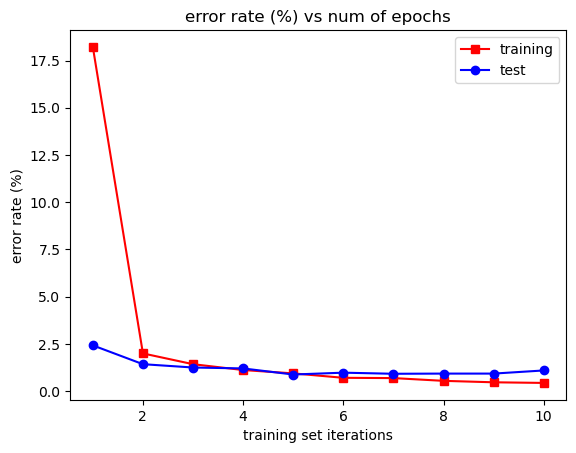

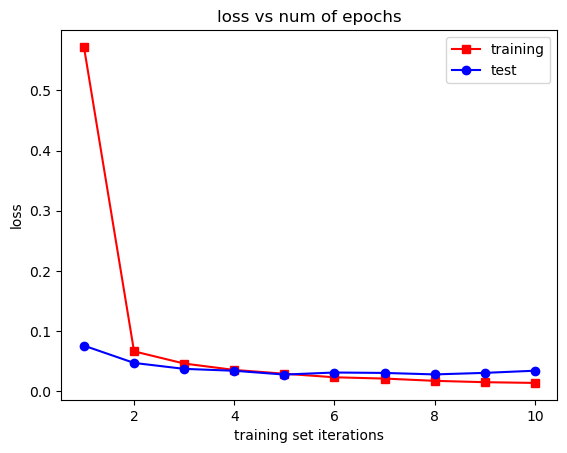

In [ ]:

# Reproduction of figure 5 in the LeNet-5 paper
train_accuracy = torch.tensor(stats['train_acc'])
test_accuracy = torch.tensor(stats['test_acc'])
train_error_rate = 100 - 100*train_accuracy
test_error_rate = 100 - 100*test_accuracy
iterations = torch.arange(1, num_epochs+1)
plt.plot(iterations, train_error_rate, marker='s', color='red', label='training')
plt.plot(iterations, test_error_rate, marker='o', color='blue', label='test')
plt.xlabel('training set iterations')
plt.ylabel('error rate (%)')
plt.title('error rate (%) vs num of epochs')
plt.legend()
plt.show()
### ACT20.2
# Same figure, but with loss on y-axis
# TODO
train_loss = torch.tensor(stats['train_loss'])
test_loss = torch.tensor(stats['test_loss'])
plt.plot(iterations, train_loss, marker='s', color='red', label='training')
plt.plot(iterations, test_loss, marker='o', color='blue', label='test')
plt.xlabel('training set iterations')
plt.ylabel('loss')
plt.title('loss vs num of epochs')
plt.legend()
plt.show()

### Inspecting Model Errors
**ACT 21**

For incorrectly classified samples, we want to check the probability the model assigned to each predictions. Please complete the code which takes in the model output of a single sample (logits) and compute the top-k (k=3 by default) possible labels assigned by the model and their corresponding softmax possibilities (value of the corresponding entries for the softmax output).


In [ ]:
def sorted_softmax_prob(logits, topk=3):
    # Compute the softmax probabilities of the logits using torch.
    p_inds =  torch.squeeze(nn.functional.softmax(logits, dim=1)) # ACT21.1-Compute the softmax for the single sample logit
    top_p, top_inds = torch.sort(p_inds, descending=True) # ACT21.2-Sort the softmax distribution
    return top_p[:topk], top_inds[:topk]

# Testing
test_input = torch.tensor([[10,3,4,2,5,9,8]]).float()
top_p, top_inds = sorted_softmax_prob(test_input)
assert torch.linalg.norm(top_p - torch.tensor([0.6606, 0.2430, 0.0894])) <= 0.01, top_p
assert torch.sum(top_inds - torch.tensor([0, 5, 6])) <= 0.01, top_inds

**ACT22**

After implementing the `sorted_softmax_prob` function, call the function in the visualization script below to check the error

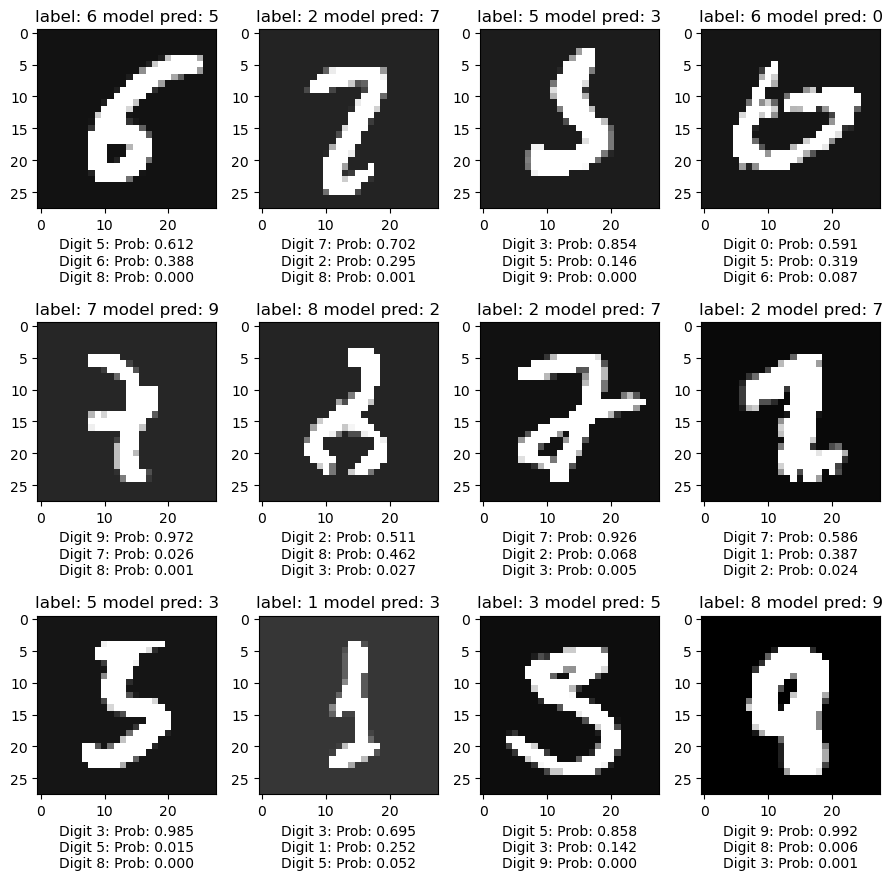

In [ ]:
def normalize_image(npimg):
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    return npimg

num_to_check = 12
num_checked = 0
test_loader_for_error_analysis = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0)
net.eval()

fig, axes = plt.subplots(3, 4, figsize=(9, 9))

with torch.no_grad():

    for data in test_loader_for_error_analysis:
        X = data[0].to(device)
        y = data[1].to(device)

        # Get the logit prediction from the model
        output = net(X)
        _, yh = torch.max(output, 1)

        if yh.item() != y.item():

            npimg = X[0][0].to('cpu').numpy()
            npimg = normalize_image(npimg)
            axes[num_checked // 4, num_checked % 4].imshow(npimg, cmap="gray", vmin=0, vmax=1)
            axes[num_checked // 4, num_checked % 4].set_title(f"label: {y.item()} model pred: {yh.item()}")

            top_p, top_inds = sorted_softmax_prob(output, 3)# ACT22

            top_possibility_str = []
            for p, ind in zip(top_p, top_inds):
              top_possibility_str.append(f"Digit {ind}: Prob: {p:.3f}")
            axes[num_checked // 4, num_checked % 4].set_xlabel("\n".join(top_possibility_str))
            num_checked += 1

            if num_checked == num_to_check:
                break

plt.tight_layout()
plt.show()

### Visualize CNN layers
Now you will visualize some internal values in the CNN. You will visualize the filters in the CNN and the result of applying those CNN filters to input images.

#### Visualize each filter separately in the first layer (ACT24)

* Our first layer was a 2d convolutional layer with 16 output channels and 5-by-5 kernel
* Therefore we have 16 different learnt filters. Each has size (1,5,5), so, each filter is a 5-by-5 array of weights
* Let's look at each filter as a 5-by-5 grayscale image and plot it


torch.Size([16, 1, 5, 5])


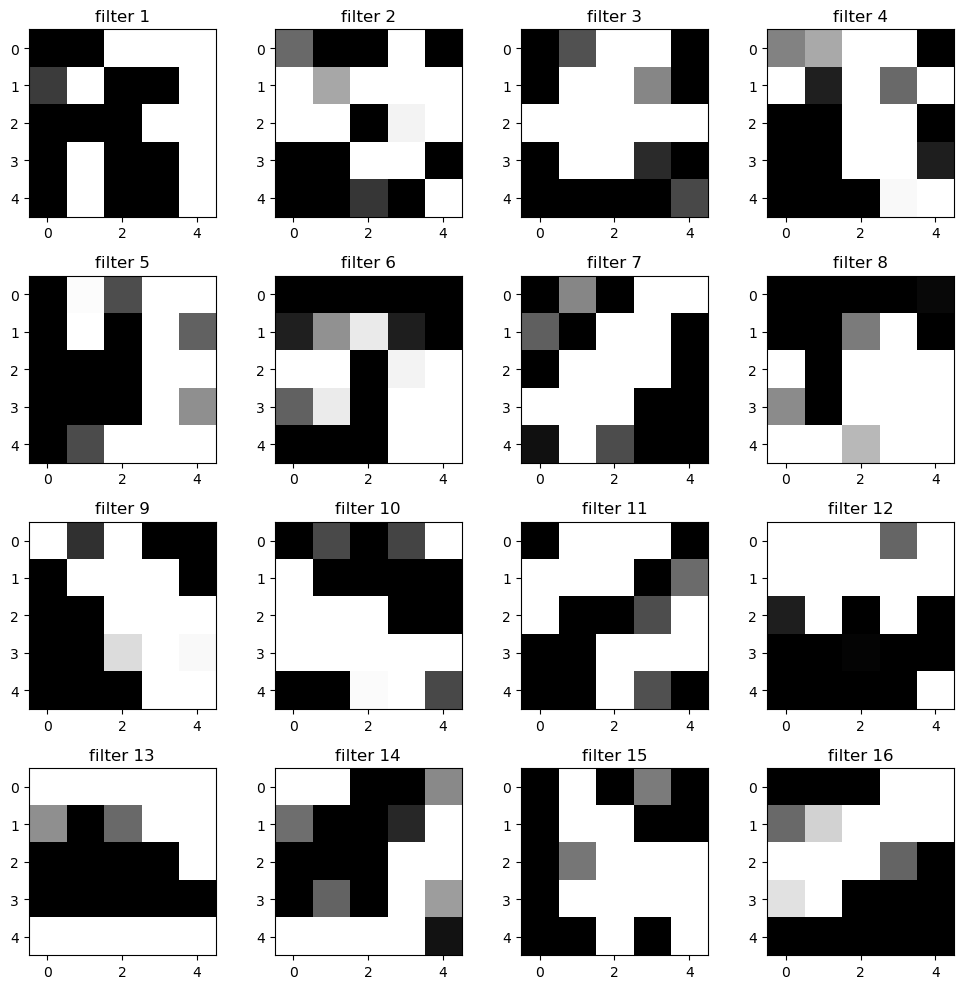

In [ ]:

print(net.conv1.weight.size())
plt.figure(figsize=(10,10))

# Enumerate all filters
for i in range(16):
    plt.subplot(4,4,i+1)
    npimg = net.conv1.weight[i].detach().cpu().numpy().squeeze() # ACT24
    npimg = normalize_image(npimg)
    npimg = normalize_image(npimg)
    plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
    plt.title(f"filter {i + 1}")

plt.tight_layout()
plt.show()

### Visualize the input after applying the first layer

*  First layer has 16 filters
*  Since padding is 2 and kernel is 5-by-5, each output channel will be again 28-by-28
*  Let's visualize each of these 16 pictures for one example of each digit

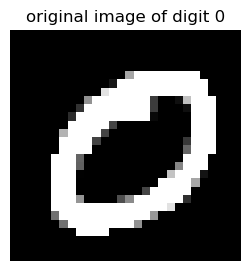

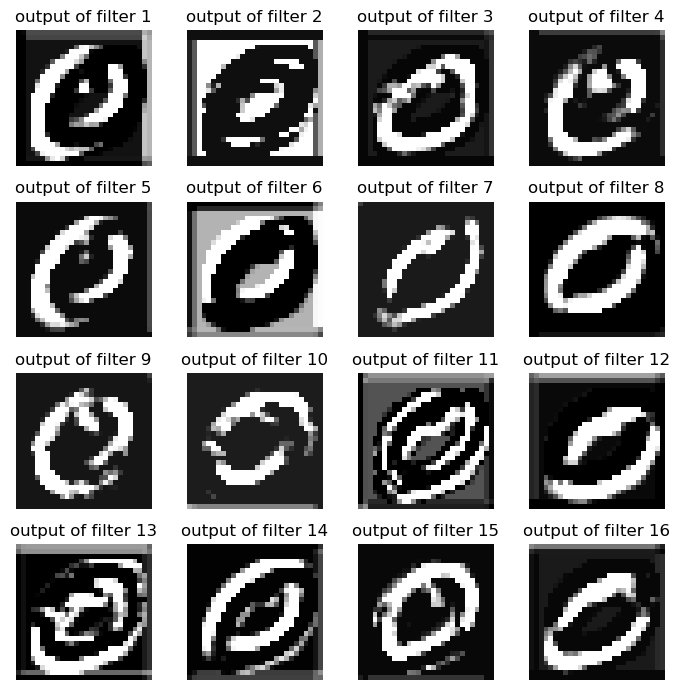

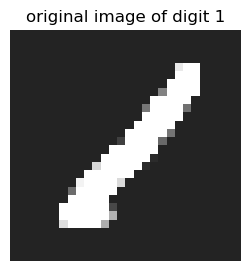

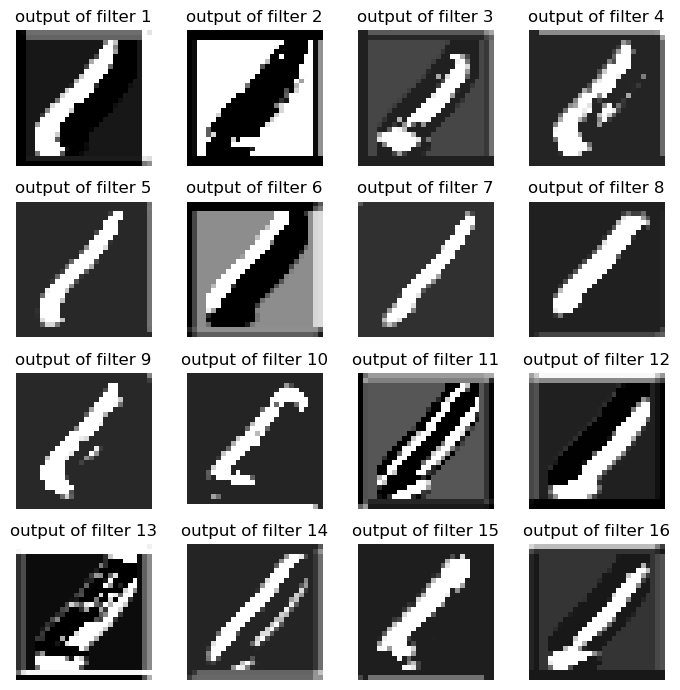

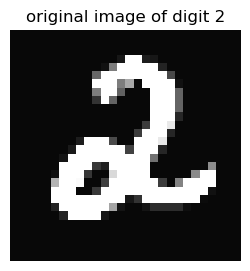

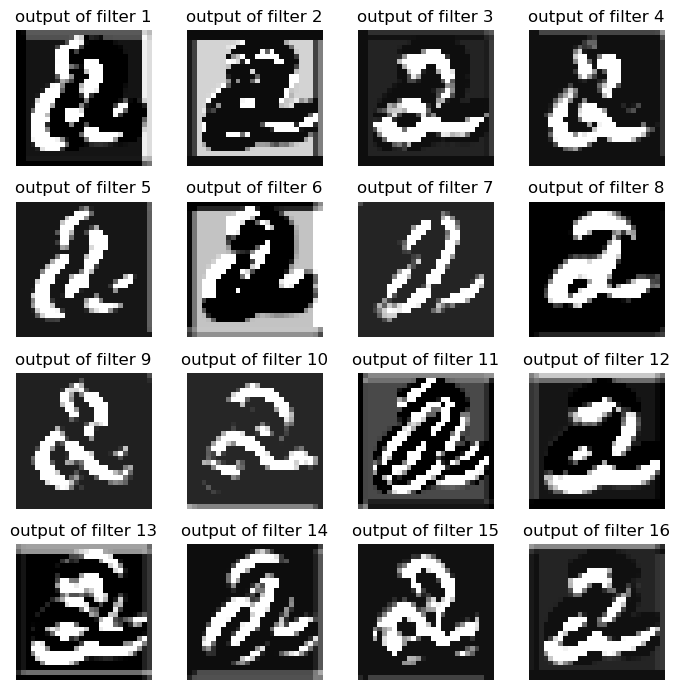

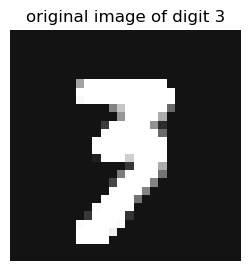

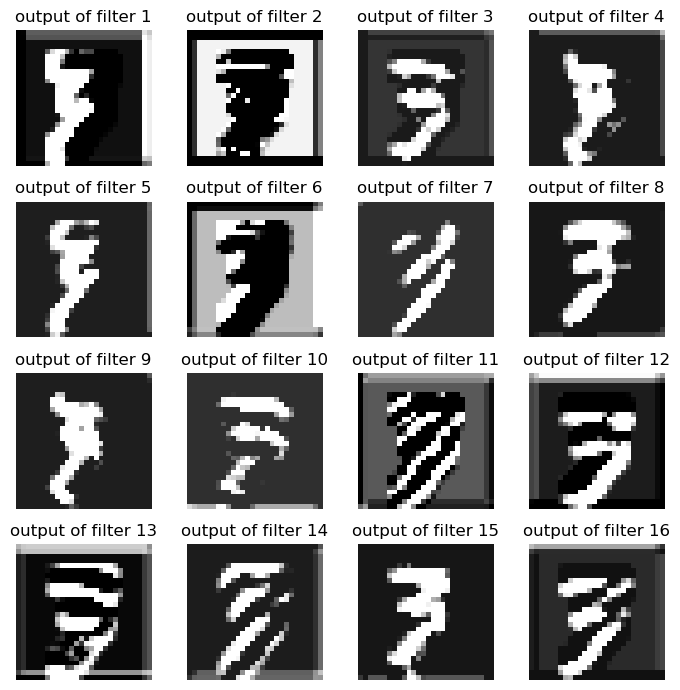

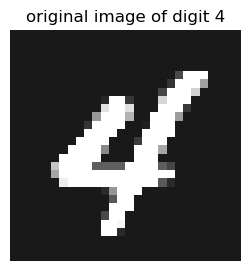

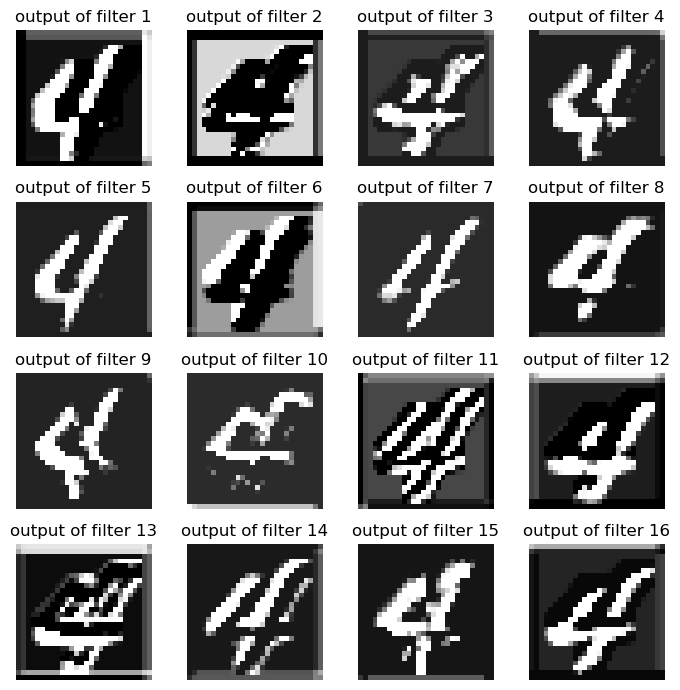

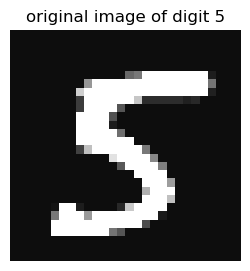

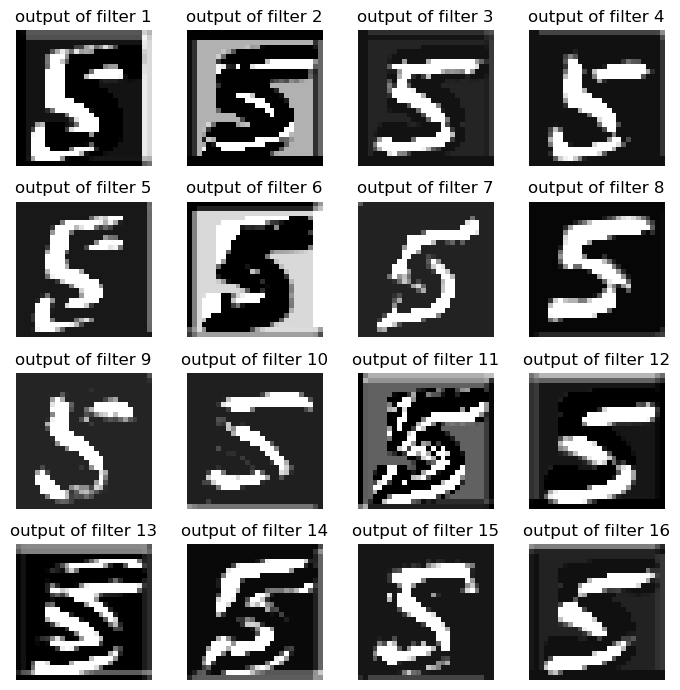

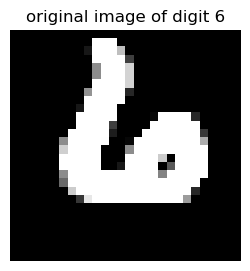

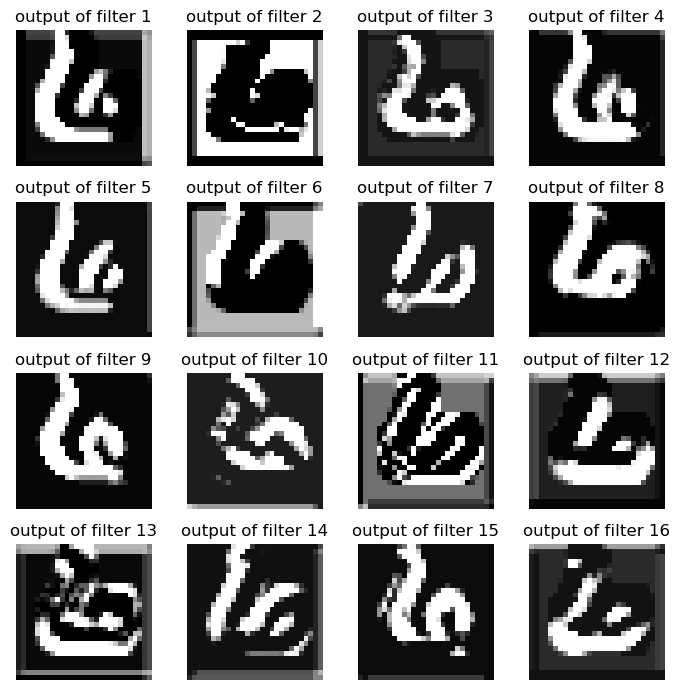

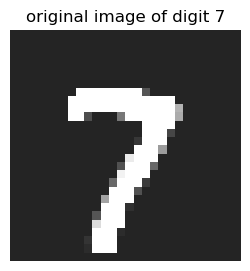

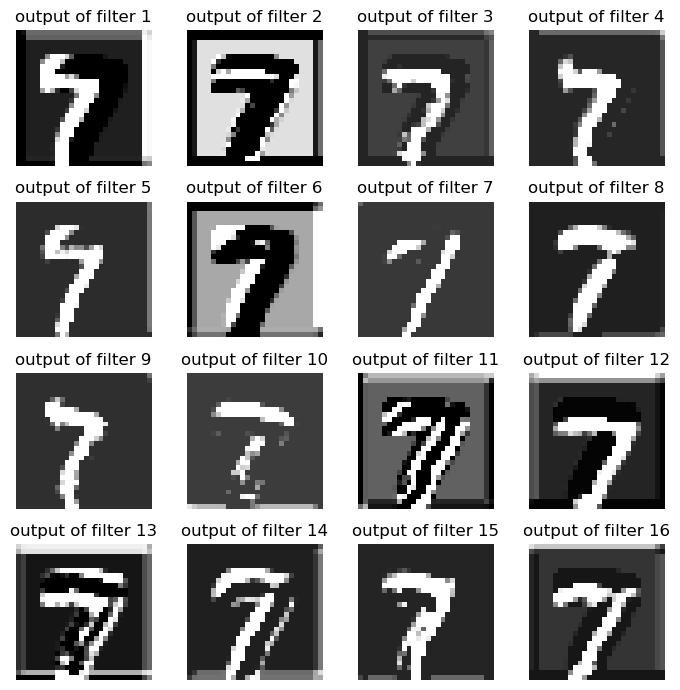

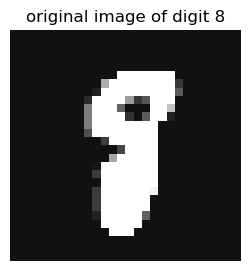

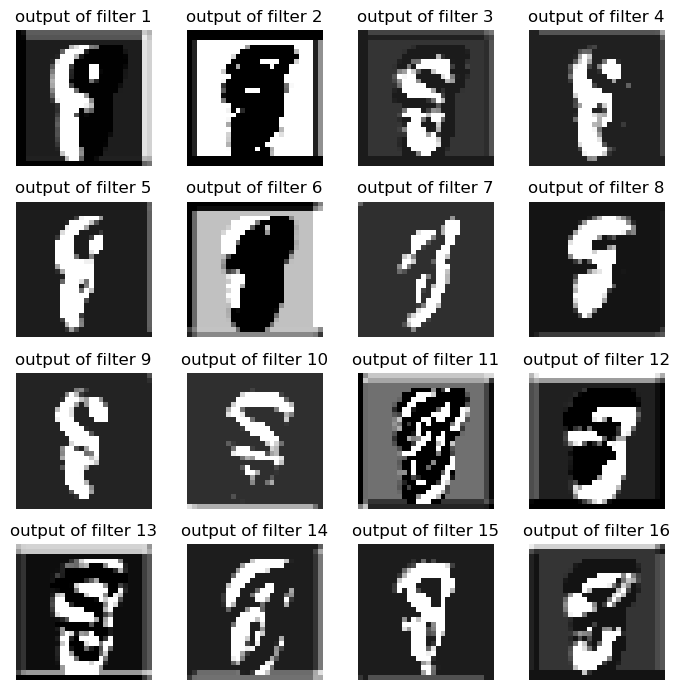

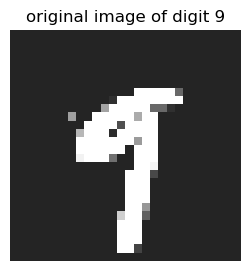

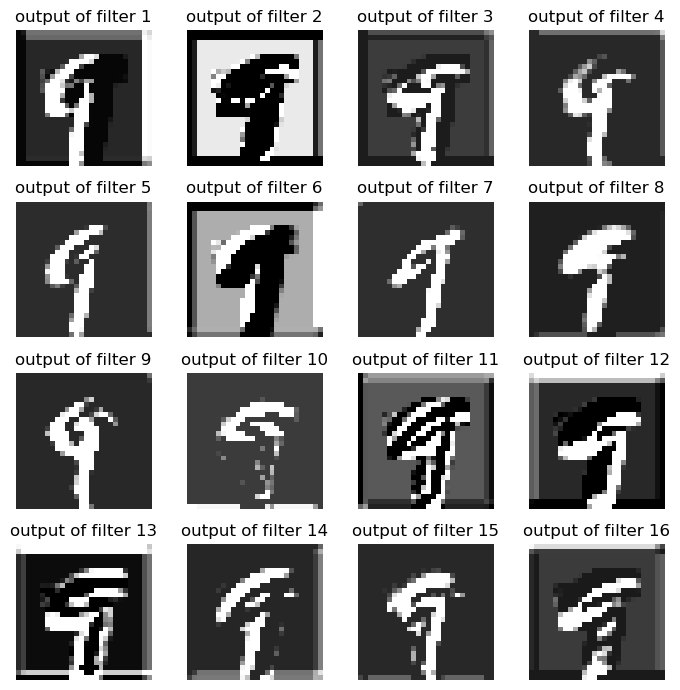

In [ ]:

sample_digits = dict()
for data in train_loader:
    for i in range(data[1].shape[0]):
        if data[1][i].item() not in sample_digits.keys():
            sample_digits[data[1][i].item()]=data[0][i]
    if len(sample_digits.keys())==10:
        break

for digit in range(10):

    data = sample_digits[digit]
    npimg = data[0].numpy()
    npimg = normalize_image(npimg)
    plt.figure(figsize=(3,3))
    plt.imshow(npimg,cmap="gray",vmin=0,vmax=1)
    plt.title("original image of digit %d"%digit)
    plt.axis("off")

    with torch.no_grad():
        data = data.unsqueeze(0).to(device)
        output_pre_relu = net.conv1(data)
        output = nn.functional.relu(output_pre_relu)

    data_numpy = output.detach().cpu().numpy()
    fig, axes = plt.subplots(4, 4, figsize=(7, 7))
    for i in range(16):
        npimg = data_numpy[0,i]
        npimg = normalize_image(npimg)
        axes[i//4, i%4].imshow(npimg,cmap="gray",vmin=0,vmax=1)
        axes[i//4, i%4].set_title("output of filter "+str(i+1))
        axes[i//4, i%4].axis('off')
    plt.tight_layout()
    plt.show()

    ###ASSERTS
    assert(data.size()==(1,1,28,28))
    assert(output.size()==(1,16,28,28))

### Comparing with a Fully Connected Neural Network (ACT28-31)

Let's make a fully connected (FC) neural network with a similar number of parameters as your ConvNet. Then, we can compare the performance between the FC net and the ConvNet.

We have seen from above that the ConvNet has 120382 parameters. Now lets construct a FC network of similar size and train the network in an identical way using the trainer framework we have constructed above.


In [ ]:
d = 120 # Find d such that the total number of parameters of FCNet is around 120000-130000

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.input_size = 28 * 28
        self.fc1 = nn.Linear(self.input_size, d)
        self.fc2 = nn.Linear(d, d)
        self.fc3 = nn.Linear(d, d)
        self.fc4 = nn.Linear(d, 10)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

count_parameters(FCNet())

fc1.weight:	 torch.Size([120, 784])
fc1.bias:	 torch.Size([120])
fc2.weight:	 torch.Size([120, 120])
fc2.bias:	 torch.Size([120])
fc3.weight:	 torch.Size([120, 120])
fc3.bias:	 torch.Size([120])
fc4.weight:	 torch.Size([10, 120])
fc4.bias:	 torch.Size([10])
Total parameters: 124450



train the FCNet using the same learning rate and number of epochs, save the stats to `stats_fc`

In [ ]:

num_epochs = 10
learning_rate = 0.03

net_fc = FCNet().to(device) # Initialize the network and send it to device
opt_fc =  optim.SGD(net_fc.parameters(), lr=learning_rate, momentum=0.9) # Define the optimizer using same hyperparameter as in ACT 16
loss_function = nn.CrossEntropyLoss()# Define the cross entropy loss objective

trainer_fc = Trainer(net_fc, opt_fc, loss_function, train_loader, test_loader) # Initialize the trainer for FCNet

stats_fc = trainer_fc.train(num_epochs) # Train the model using trainer_fc and save the stats

Testing: 100%|██████████| 40/40 [00:01<00:00, 35.61it/s, loss=0.1493, acc=93.75%] 


Epoch 1: train loss 0.5613, train acc 83.07%, test loss 0.1740, test acc 94.68%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.69it/s, loss=0.0075, acc=100.00%]


Epoch 2: train loss 0.1372, train acc 95.85%, test loss 0.1072, test acc 96.59%



Testing: 100%|██████████| 40/40 [00:01<00:00, 35.88it/s, loss=0.0069, acc=100.00%]


Epoch 3: train loss 0.0914, train acc 97.19%, test loss 0.0901, test acc 97.28%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.80it/s, loss=0.0024, acc=100.00%]


Epoch 4: train loss 0.0668, train acc 97.93%, test loss 0.0804, test acc 97.48%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.71it/s, loss=0.0018, acc=100.00%]


Epoch 5: train loss 0.0524, train acc 98.33%, test loss 0.0896, test acc 97.22%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.90it/s, loss=0.0003, acc=100.00%]


Epoch 6: train loss 0.0430, train acc 98.62%, test loss 0.0949, test acc 97.09%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.74it/s, loss=0.0003, acc=100.00%]


Epoch 7: train loss 0.0327, train acc 98.96%, test loss 0.0742, test acc 97.65%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.77it/s, loss=0.0400, acc=100.00%]


Epoch 8: train loss 0.0282, train acc 99.10%, test loss 0.0768, test acc 97.76%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.88it/s, loss=0.0001, acc=100.00%]


Epoch 9: train loss 0.0196, train acc 99.39%, test loss 0.0874, test acc 97.47%



Testing: 100%|██████████| 40/40 [00:01<00:00, 34.76it/s, loss=0.0000, acc=100.00%]

Epoch 10: train loss 0.0196, train acc 99.37%, test loss 0.0793, test acc 97.70%





Visualize the training statistics

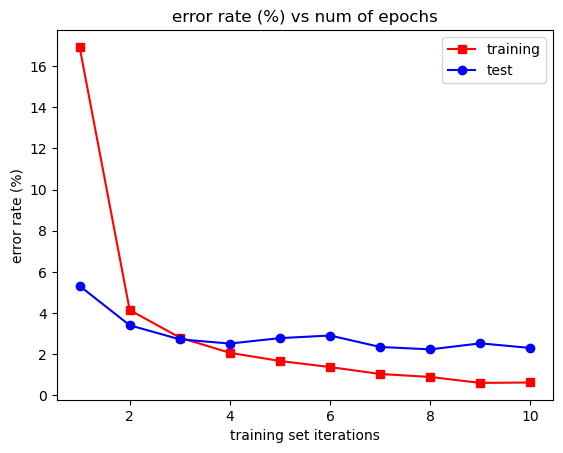

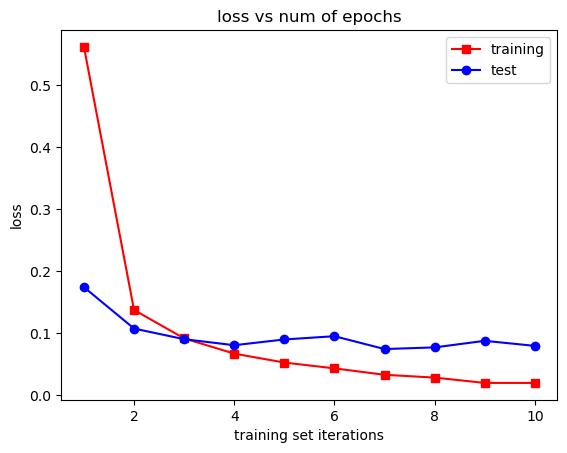

In [ ]:

# Training and Testing Error Rate for FCNet
train_accuracy = torch.tensor(stats_fc['train_acc'])
test_accuracy = torch.tensor(stats_fc['test_acc'])
train_error_rate = 100 - 100*train_accuracy
test_error_rate = 100 - 100*test_accuracy
iterations = torch.arange(1, num_epochs+1)
plt.plot(iterations, train_error_rate, marker='s', color='red', label='training')
plt.plot(iterations, test_error_rate, marker='o', color='blue', label='test')
plt.xlabel('training set iterations')
plt.ylabel('error rate (%)')
plt.title('error rate (%) vs num of epochs')
plt.legend()
plt.show()


# Training and Testing Loss
# Same figure, but with loss on y-axis
train_loss = torch.tensor(stats_fc['train_loss'])
test_loss = torch.tensor(stats_fc['test_loss'])
plt.plot(iterations, train_loss, marker='s', color='red', label='training')
plt.plot(iterations, test_loss, marker='o', color='blue', label='test')
plt.xlabel('training set iterations')
plt.ylabel('loss')
plt.title('loss vs num of epochs')
plt.legend()
plt.show()